# Project 5: Deadpan Dog Analysis
An analysis, *sans* emotion, of the overemotional rating of dogs by the WeRateDogs twitter account.

*This project is for Unit 4, Data Wrangling, of the Data Analyst Nanodegree from Udacity*

## Table of Contents
<ul>
<li><a href='#intro'>Introduction</a></li>
<li><a href='#wrangling'>Data Wrangling</a></li>
    <ul>
    <li><a href='#gather'>Gathering Data</a></li>
    <li><a href='#assess'>Assessing Data</a></li>
    <li><a href='#clean'>Cleaning Data</a></li>
    </ul>
<li><a href='#eda'>Exploratory Data Analysis</a></li>
<li><a href='#stats'>Statistical Analysis</a></li>
<li><a href='#conclusions'>Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
In this project, I will be working with the WeRateDogs Twitter account's tweets. This is a combination of the following sources:

- Archived Twitter Data (provided as a "file on hand" by Udacity)
- Image Predictions for Tweets (requested from a Udacity-hosted neural network)
- Additional Tweet Metadata (queried via Twitter API)

### Questions
1. What is the relationship between rating values and favorite count?
2. What are the most common dog image predictions?
3. How have rating values been trending over time?
4. Are retweet count, time, or rating values good predictors of favorite count?

In [1]:
#importing necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import tweepy
import json
from patsy import dmatrices
import statsmodels.api as sm;
from statsmodels.stats.outliers_influence import variance_inflation_factor
from timeit import default_timer as timer

<a id='wrangling'></a>
## Data Wrangling
<ul>
<li><a href='#gather'>Gathering Data</a></li>
<li><a href='#assess'>Assessing Data</a></li>
<li><a href='#clean'>Cleaning Data</a></li>
</ul>

<a id='gather'></a>
### Gathering Data

In [2]:
#reading in the Archived Twitter Data file into a data frame
df_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
#pulling Image Predictions from Udacity-hosted file online
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)
with open(url.split('/')[-1], 'wb') as file:
    file.write(r.content)

In [4]:
#reading in the newly created Image Predictions file as a data frame
df_predict = pd.read_csv('image-predictions.tsv', sep='\t')

In [5]:
#scraping metadata JSON using twitter API
Note: the four variables used in the arguments for lines 4 and 5 were removed for privacy
start = timer()
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

lost_tweets = []
with open('tweet_json.txt', 'w') as file:
    for tweet_id in df_archive.tweet_id:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            json.dump(tweet._json, file)
            file.write('\n')
        except tweepy.TweepError as te:
                lost_tweets.append(tweet_id)
end = timer()
print('Time Elapsed:', end - start)

In [6]:
#reading in the newly created JSON file of tweet metadata as a data frame
df_meta = pd.read_json('tweet_json.txt', lines=True)

<a id='assess'></a>
### Assessing Data

In [7]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [8]:
df_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [9]:
df_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [10]:
df_archive[df_archive.rating_denominator != 10].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,30582082.0,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None


In [11]:
#investigating reason for wonky rating_numerator or rating_denominator
print(df_archive.iloc[313].text)

@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho


In [12]:
#investigating source looking so strange
df_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [13]:
#seeing if dog "stage" columns are mutually exclusive
df_archive[['doggo', 'floofer', 'pupper', 'puppo']].query('pupper != "None" & doggo != "None"')

,doggo,floofer,pupper,puppo
460,doggo,None,pupper,None
531,doggo,None,pupper,None
565,doggo,None,pupper,None
575,doggo,None,pupper,None
705,doggo,None,pupper,None
733,doggo,None,pupper,None
778,doggo,None,pupper,None
822,doggo,None,pupper,None
889,doggo,None,pupper,None
956,doggo,None,pupper,None


In [14]:
df_archive.iloc[889].text

'Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll'

In [15]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [16]:
df_predict.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [17]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2331 non-null   datetime64[ns, UTC]
 1   id                             2331 non-null   int64              
 2   id_str                         2331 non-null   int64              
 3   full_text                      2331 non-null   object             
 4   truncated                      2331 non-null   bool               
 5   display_text_range             2331 non-null   object             
 6   entities                       2331 non-null   object             
 7   extended_entities              2059 non-null   object             
 8   source                         2331 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

In [18]:
df_meta.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


In [19]:
#investigating id vs id_str
df_predict[df_predict.tweet_id == 892420643555336193]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.07611,False


#### Issues

##### Quality

1. Tweet id is referred to inconsistently across tables
2. There are many empty columns and columns that aren't needed (and are therefore invalid)

`df_archive`
3. Archived data contains 181 retweets, which are invalid based on our desire for original tweets only
4. `rating_denominator` data should all be 10, but some are very far off, most due to scraping the wrong numbers from the text.
5. `rating_numerator` values have a similar problem to the denominator
6. `timestamp` is object type, and should be datetime type.
7. `source` is invalid as it contains the whole hyperlink html tag. This should be a simpler categorical data format preferably a one word string.

`df_meta`
8. Data is incomplete since some tweets were not able to be pulled by the API (IDs were stored in `lost_tweets` and can also be found comparing to df_archive)
9. `id` does not match `id_str` for some tweets, and `id` matches the id used in the other two tables.
10. `tweet_id` should be type str, not int

##### Tidiness
1. Data is split across three dataframes and three files, but only has two main observational units, i.e., tweet data and tweet image predictions
2. Duplicated information (tweet id in 4 columns, text in both `df_archive` and `df_meta`)
3. In `df_archive`, the dog "stage" descriptions should be one column instead of 4 since it's mostly exclusive categorical data
4. Rating should really just be one column, since the rating is one observation.

<a id='clean'></a>
### Cleaning Data

In [20]:
#making clean copies to work with. `df_tweet` will be the clean combined version of df_archive and df_meta
df_tweet = df_archive.copy()
df_meta_clean = df_meta.copy()
df_predict_clean = df_predict.copy()

In [21]:
df_tweet.set_index('tweet_id', inplace=True)

#### `df_archive` Archived data contains 181 retweets, which are invalid based on our desire for original tweets only. Data is incomplete since some tweets were not able to be pulled by the API (IDs were stored in lost_tweets and can also be found comparing to df_archive).

##### Describe
Drop rows from `df_archive` using the `retweeted_status_id` column as an indicator for being a retweet.

##### Code

In [22]:
df_tweet.drop(df_tweet[df_tweet.retweeted_status_id.notna()].index, inplace=True)

##### Test

In [23]:
df_tweet.shape

(2175, 16)

In [24]:
df_tweet.retweeted_status_id.isna().sum()

2175

#### Tweet id is referred to inconsistently across tables
##### Describe
Rename the `id` column in `df_meta` to be `tweet_id` to match the other two tables.
##### Code

In [25]:
df_meta_clean.rename(columns={'id':'tweet_id'}, inplace=True)

In [26]:
df_meta_clean.head(1)

,created_at,tweet_id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


#### There are many empty columns and columns that aren't needed (and are therefore invalid), in all three df
##### Describe
Redefine `df_meta_clean` and drop columns in `df_tweet` to only include the columns that will be useful in analysis later
##### Code

In [27]:
df_meta_clean = df_meta_clean.copy()[['tweet_id', 'created_at', 'retweet_count', 'favorite_count']]
df_tweet.drop(columns=['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'],inplace=True)

##### Test

In [28]:
df_meta_clean.head(1)

,tweet_id,created_at,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,7650,35960


In [29]:
df_tweet.head(1)

,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
tweet_id,,,,,,,,,,,
892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


#### Data is split across three dataframes and three files, but only has two main observational units, i.e., tweet data and tweet image predictions

##### Describe
Merge in the timestamp, retweet count, and favorite count data from `df_meta`. This will also incidentally fix the id vs id_str problem and eliminate having to deal with the extra columns in `df_meta`, and the tidiness issue of duplicate information (like id in 4 places). Merging "inner" also avoids the problem of deleted tweets in the archived data by only keeping the tweets that were able to be pulled by the API.
##### Code

In [30]:
df_tweet = pd.merge(df_tweet, df_meta_clean, on='tweet_id')

##### Test

In [31]:
df_tweet.shape

(2168, 15)

In [32]:
df_tweet.head(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,created_at,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,2017-08-01 16:23:56+00:00,7650,35960


#### `timestamp` is object type, and should be datetime type.
##### Describe
Drop `timestamp` column and use `created_at` instead
##### Code

In [33]:
df_tweet.drop(columns='timestamp', inplace=True)

##### Test

In [34]:
df_tweet.columns

Index(['tweet_id', 'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'created_at', 'retweet_count', 'favorite_count'],
      dtype='object')

#### In `df_archive`, The dog "stage" descriptions should be one column instead of 4. 
##### Describe
Replace None with empty strings and then make a new column for `dog_stage` concatenating the columns. Replace any non-mutually exclusive data with "multiple" and drop the existing 4 columns.
##### Code

In [35]:
df_tweet.replace(to_replace='None', value='', inplace=True)
df_tweet['dog_stage'] = (df_tweet.doggo + df_tweet.floofer + df_tweet.pupper + df_tweet.puppo)

In [36]:
df_tweet.dog_stage.replace(to_replace=['doggopupper','doggopuppo','doggofloofer'], value='multiple', inplace=True)
df_tweet.dog_stage.replace(to_replace='', value=np.nan, inplace=True)

In [37]:
df_tweet.drop(columns=['doggo','floofer','pupper','puppo'], inplace=True)

##### Test

In [38]:
df_tweet.dog_stage.value_counts()

pupper      224
doggo        74
puppo        24
multiple     12
floofer       9
Name: dog_stage, dtype: int64

In [39]:
df_tweet.head(1)

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,created_at,retweet_count,favorite_count,dog_stage
0,892420643555336193,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,2017-08-01 16:23:56+00:00,7650,35960,NaN


#### `source` column is invalid as it contains the whole hyperlink html tag. This should be a simpler categorical data format preferably a one word string.
##### Describe
Use the pd.Series.str.replace() method to find the identifying informatoin about the source of the Tweet, and discard the rest.
##### Code

In [40]:
replacements = dict(zip(list(df_tweet.source.value_counts().index), ['iPhone','Vine','Website','Desktop']))
df_tweet.source.replace(replacements, inplace=True) 

##### Test

In [41]:
df_tweet.source.value_counts()

iPhone     2036
Vine         91
Website      31
Desktop      10
Name: source, dtype: int64

#### `rating_denominator` data should all be 10, but some are very far off, most due to scraping the wrong numbers from the text. `rating_numerator` values have a similar problem to the denominator. Some may have not have ratings, and some may just be pulling the wrong number.
##### Describe
Since only 22 rows of the 2168 row dataset remaining have these types of issues, I'm just going to drop the affected rows (of denominators >10). The amount of effort and time required would not be worth it to either write a function to programmatically select the correct numbers for each situation or go through all 22 manually. I will check the numerators after dropping rows to see if there are large outliers there still.
##### Code

In [42]:
df_tweet.drop(df_tweet[df_tweet.rating_denominator != 10].index, inplace=True)

In [43]:
df_tweet[df_tweet.rating_numerator > 10].rating_numerator.value_counts()

12      498
11      425
13      303
14       43
420       2
1776      1
666       1
182       1
75        1
27        1
26        1
17        1
15        1
Name: rating_numerator, dtype: int64

These remaining outliers are still too much. 1776 will really skew the data, although it is technically a valid rating. I think the analysis will be more poignant and informative without those outliers, although they're interesting and I will note them in my report.

In [44]:
df_tweet.drop(df_tweet.query('rating_numerator > 50').index, inplace=True)

##### Test

In [45]:
df_tweet[df_tweet.rating_denominator != 10].tweet_id.count()

0

In [46]:
df_tweet[df_tweet.rating_numerator > 50].text.values

array([], dtype=object)

In [47]:
df_tweet.shape

(2140, 11)

#### Rating should really just be one column, since the rating is one observation.
##### Describe
Drop the `rating_denominator` column, because they're all 10 now, so it gives no additional information.
##### Code

In [48]:
df_tweet.drop(columns='rating_denominator', inplace=True)

##### Test

In [49]:
df_tweet.columns

Index(['tweet_id', 'source', 'text', 'expanded_urls', 'rating_numerator',
       'name', 'created_at', 'retweet_count', 'favorite_count', 'dog_stage'],
      dtype='object')

#### `tweet_id` should be type str, not int
##### Describe
Use df.astype() to convert the `tweet_id` column in both df_tweet and df_predict to str instead of int
##### Code

In [50]:
df_tweet.tweet_id = df_tweet.tweet_id.astype(str)
df_predict_clean.tweet_id = df_predict_clean.tweet_id.astype(str)

<a id='eda'></a>
## Exploratory Data Analysis

### General Exploration

In [51]:
df_tweet.describe()

,rating_numerator,retweet_count,favorite_count
count,2140.000000,2140.000000,2140.000000
mean,10.631308,2430.207009,8095.396729
std,2.252016,4326.607455,11930.125451
min,0.000000,1.000000,50.000000
25%,10.000000,525.500000,1708.000000
50%,11.000000,1158.500000,3653.000000
75%,12.000000,2776.750000,10058.000000
max,27.000000,77153.000000,155168.000000


In [52]:
df_predict_clean.describe()

,img_num,p1_conf,p2_conf,p3_conf
count,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,1.203855,0.594548,1.345886e-01,6.032417e-02
std,0.561875,0.271174,1.006657e-01,5.090593e-02
min,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,1.000000,0.843855,1.955655e-01,9.180755e-02
max,4.000000,1.000000,4.880140e-01,2.734190e-01


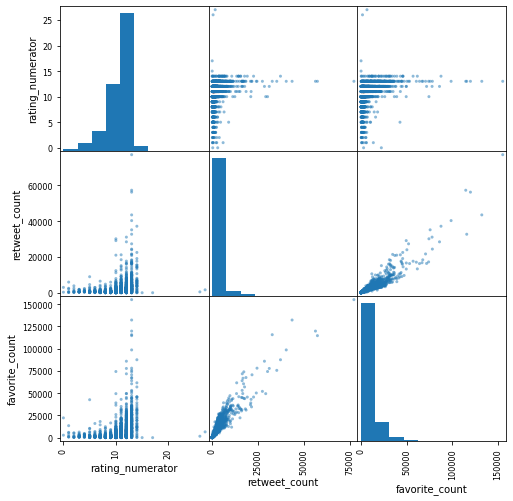

In [53]:
pd.plotting.scatter_matrix(df_tweet, figsize=(8,8));

#### As expected, favorite count and retweet count look highly correlated (both gauging the popularity of a tweet). I'd like to get a closer look at the bottom-left graph to answer question 1, so I'll graph it again below.

### 1. What is the relationship between rating values and favorite count?

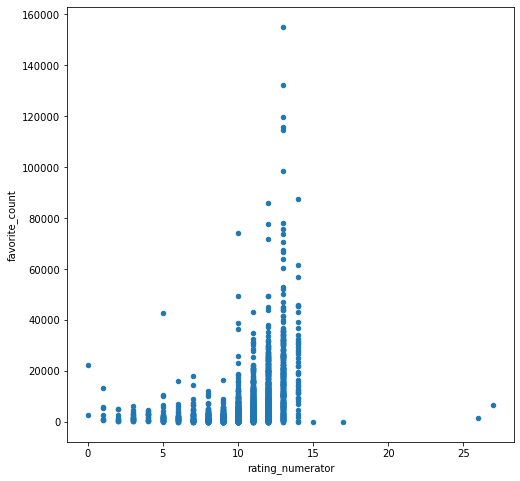

In [54]:
df_tweet.plot.scatter('rating_numerator','favorite_count', figsize=(8,8));

The favorite count is in fact positively correlated with rating numberator. However, this also suspiciously looks like exponential growth to me.

### 2. What are the most common dog image predictions?

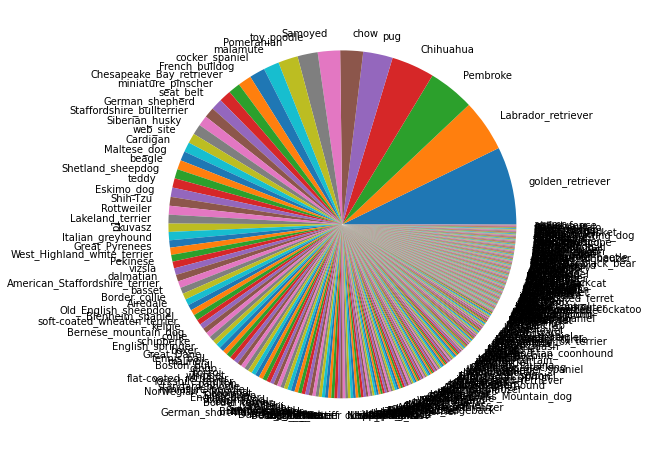

In [55]:
df_predict_clean.p1.value_counts().plot(kind='pie', figsize=(8,8));

#### While the above chart may be hard to read, my goal was really just to determine the top 5 or so, which we can easily see as:
1. Golden Retriever
2. Labrador Retriever
3. Pembroke
4. Chihuahua
5. Pug

### 3. How have rating values been trending over time?

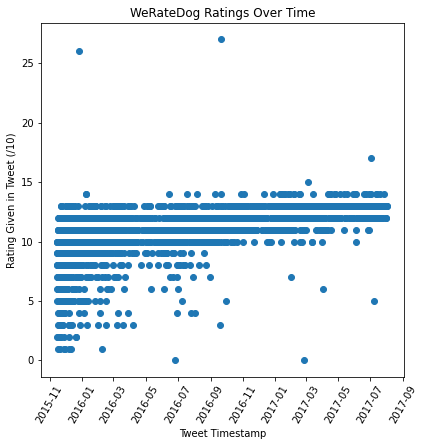

In [56]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.xticks(rotation=60)
plt.xlabel('Tweet Timestamp')
plt.ylabel('Rating Given in Tweet (/10)')
plt.title('WeRateDog Ratings Over Time')
plt.scatter(df_tweet.created_at, df_tweet.rating_numerator);

#### There has been an obvious inflation of ratings from 2015 to 2017, resulting in less than 5 ratings under 10 since 2017. It might be interesting to see what those 4, in particular, are.

<a id='stats'></a>
## Statistical Analysis

### 4. Are retweet count, time, or rating values good predictors of favorite count?
In order to solve this question, I'm going to first examine multicollinearity to be sure that it's viable to fit a linear regression or multiple linear regression to this data.

In [57]:
#converting 'created_at' column to a new column of date float values based on the days passed since the first tweet observed
df_tweet['timestamp_delta'] = (df_tweet['created_at'] - df_tweet['created_at'].min())  / np.timedelta64(1,'D')

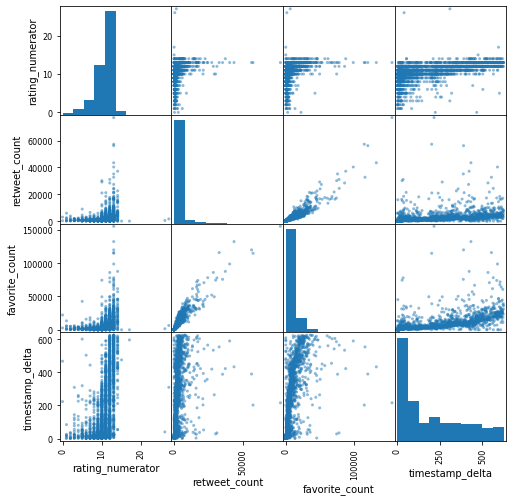

In [58]:
#looking at a scatter plot matrix to examine relationships between variables
pd.plotting.scatter_matrix(df_tweet, figsize=(8,8));

In [59]:
#checking VIFs to test the multicollinearity
y, X = dmatrices('favorite_count ~ retweet_count + timestamp_delta + rating_numerator', df_tweet, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,25.712583,Intercept
1,1.172340,retweet_count
2,1.444440,timestamp_delta
3,1.350151,rating_numerator


Strangely, the VIF test isn't showing any multicollinearity, so we will try an OLS multilinear regression.

In [60]:
df_tweet['intercept'] = 1
mod = sm.OLS(df_tweet.favorite_count, df_tweet[['intercept', 'timestamp_delta', 'retweet_count', 'rating_numerator']])
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     9879.
Date:                Wed, 29 Jul 2020   Prob (F-statistic):               0.00
Time:                        18:07:07   Log-Likelihood:                -20235.
No. Observations:                2140   AIC:                         4.048e+04
Df Residuals:                    2136   BIC:                         4.050e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept         -111.2056    339.297     -0.328      0.743    -776.593     554.182
timestamp_delta     19.3393      0.432     44.767      0.000      18.492      20.186
retweet_count        2.2621      0.017    135.057      0.000       2.229       2.295
rating_numerator  -100.8881     34.533     -2.922      0.004    -168.609     -33.167
==============================================================================
Omnibus:                      986.746   Durbin-Watson:                   1.431
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39852.920
Skew:                           1.472   Prob(JB):                         0.00
Kurtosis:                      23.935   Cond. No.                     2.53e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Although the r-squared is very good, this is a nonsensical result, as the rating_numerator cannot be in the negatives, and neither can the favorite_count. Having an intercept of -111 is invalid. So, I'm throwing out this result and going to try linear regressions for each feature individually.

In [64]:
mod = sm.OLS(df_tweet.favorite_count, df_tweet[['intercept', 'timestamp_delta']])
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     1171.
Date:                Wed, 29 Jul 2020   Prob (F-statistic):          4.87e-205
Time:                        18:14:41   Log-Likelihood:                -22656.
No. Observations:                2140   AIC:                         4.532e+04
Df Residuals:                    2138   BIC:                         4.533e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept         641.8242    300.727      2.134      0.033      52.077    1231.572
timestamp_delta    38.1151      1.114     34.220      0.000      35.931      40.299
==============================================================================
Omnibus:                     2575.754   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           367675.681
Skew:                           6.241   Prob(JB):                         0.00
Kurtosis:                      65.989   Cond. No.                         392.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
mod = sm.OLS(df_tweet.favorite_count, df_tweet[['intercept', 'retweet_count']])
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                 1.295e+04
Date:                Wed, 29 Jul 2020   Prob (F-statistic):               0.00
Time:                        18:12:47   Log-Likelihood:                -21033.
No. Observations:                2140   AIC:                         4.207e+04
Df Residuals:                    2138   BIC:                         4.208e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      1887.2471    111.374     16.945      0.000    1668.835    2105.659
retweet_count     2.5546      0.022    113.802      0.000       2.511       2.599
==============================================================================
Omnibus:                      591.181   Durbin-Watson:                   0.818
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14883.501
Skew:                           0.722   Prob(JB):                         0.00
Kurtosis:                      15.839   Cond. No.                     5.69e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [63]:
mod = sm.OLS(df_tweet.favorite_count, df_tweet[['intercept', 'rating_numerator']])
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     313.3
Date:                Wed, 29 Jul 2020   Prob (F-statistic):           1.57e-65
Time:                        18:12:56   Log-Likelihood:                -22978.
No. Observations:                2140   AIC:                         4.596e+04
Df Residuals:                    2138   BIC:                         4.597e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept        -1.204e+04   1162.757    -10.354      0.000   -1.43e+04   -9758.896
rating_numerator  1893.8916    106.998     17.700      0.000    1684.061    2103.722
==============================================================================
Omnibus:                     2088.494   Durbin-Watson:                   1.560
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           126610.800
Skew:                           4.593   Prob(JB):                         0.00
Kurtosis:                      39.545   Cond. No.                         52.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<a id='conclusions'></a>
## Conclusions

In [68]:
#save data to external file to be called in act_report
df_tweet.to_csv('tweet_data.csv', index=False)
df_predict_clean.to_csv('image_predict.csv', index=False)

This dataset has a wealth of information. Investigating a few options, we were able to learn the following:
#### These are, probably, the most popular dogs to be featured in images of WeRateDogs tweets:
1. Golden Retriever
2. Labrador Retriever
3. Pembroke
4. Chihuahua
5. Pug

#### At first glance, it may look like higher ratings give higher favorite counts. However, the correlation is in fact small (r-squared = .128) and is outweighed by the correlation with time (r-squared = .354). Given this, the trend towards more inflated ratings over time, and the exponential looking relationship, the higher favorite counts might be due to exponential growth in the popularity's account, otherwise known as becoming "more viral". It would be interesting to investigate further, but I do not have enough tools at this point to do so.

#### Retweet count is a great predictor of favorite count (r-squared = .858), with each additional retweet resulting in ~2.5 favorites.